# Problem statement: 
Suppose that a marketing agency has many customers that use their service to produce ads for the client/customer websites. They've noticed that they have quite a bit of churn in clients. They basically randomly assign account managers right now, but want you to create a machine learning model that will help predict which customers will churn (stop buying their service) so that they can correctly assign the customers most at risk to churn an account manager. Luckily they have some historical data, can you help them out. 
In this project, I create 3 different classification algorithm that will help classify whether or not a customer churned. 

* The data has 900 rows and 10 variables.
* Dataset is imbalanced: 150 customers churn, vs. 750 customers do not churn
* This is a binary classification problem. The classification goal is to predict whether or not a customer will churn.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the missing values, etc.)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicated values, etc. 
- Basic data exploration
- Preparing data for Machine Learning:
    - One-hot-encoding of categorical features
    - Vector Assembling
    - Splitting data into training & test parts (I use the training part for training & hyperparameter tuning of models, test part for the final evaluation of models)
    
 # Model Training: 
- I separately train following models:
     - Logistic Regression (LR)
     - Random Forest (RF)
     - Gradient Boosting Trees (GBTs)
     
 Note: I use Grid-Search technique to find optimal hyper-parameters of each model. Also, I undersample the majority class to even the imbalances. 

  # Model Evaluation: 
- I separately evaluate the best LR, RF and GBT models, by calculating/plotting following mertics on Test dataset:
     - roc_auc score
     - f1 score
     - Confusion matrix
     - ROC curve  
     - Average precision
 
 
- Calculating the Feature Importance with RF and GBTs models.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import findspark 
findspark.init('/home/rhashemee/spark-2.1.0-bin-hadoop2.7')

import pyspark

import sklearn
import numpy as np
import pandas as pd
import imblearn as im
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# helpful function to detect the Missing Values:
def detect_missing(df):
    import pyspark.sql.functions as fn
    miss_count=df.agg(*[(fn.count('*')-fn.count(c)).alias(c)   for c in df.columns]).toPandas()
    miss_percent=df.agg(*[(1-(fn.count(c)/fn.count('*'))).alias(c)   for c in df.columns]).toPandas()
    
    summary = pd.concat([miss_count, miss_percent], axis=0)
    summary['  '] = ['Count of miss values: ', 'Percentage of miss values: ']
    summary.set_index('  ', inplace=True)
    return summary

# helpful function to detect the Duplicate Values:
def detect_duplicates(df):
    print('Count of rows: ', df.count())
    print('Count of distinct rows: ', df.distinct().count())

In [3]:
from pyspark.sql import SparkSession
my_spark=SparkSession.builder.appName('customer_churn').getOrCreate()

In [4]:
df=my_spark.read.csv('customer_churn.csv', header=True, inferSchema=True)

In [5]:
df.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [6]:
pd.DataFrame(df.take(3), columns=df.columns)

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1


In [7]:
# df.describe().toPandas()

In [8]:
df.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



In [9]:
company_count=df.groupBy('Company').count()
company_count.orderBy(company_count['count'].desc()).show(5)

+--------------+-----+
|       Company|count|
+--------------+-----+
|Anderson Group|    4|
|    Wilson PLC|    3|
|  Williams PLC|    3|
|      Soto PLC|    2|
|     Ortiz Ltd|    2|
+--------------+-----+
only showing top 5 rows



In [10]:
# Check for missing Values
detect_missing(df)

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
,,,,,,,,,,
Count of miss values:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage of miss values:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Check for Duplicates: 
detect_duplicates(df)

# df.dropDuplicates() # Drop duplicate values

Count of rows:  900
Count of distinct rows:  900


In [12]:
# select label + informative features:
df_selected = df.select('Age', 'Total_Purchase', 'Years', 'Num_Sites', 'Churn')

In [13]:
df_selected.printSchema()

root
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [14]:
# Preparing Data for Machine Learning: ___________________________

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# One-Hot-Encoding of Categorical features:
categoricalColumns = [] # ['Company']
stages = []

for categoricalCol in categoricalColumns:
    
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_Index')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=categoricalCol + "_classVec")
    stages += [stringIndexer, encoder]

# Label:    
label_stringIdx = StringIndexer(inputCol = 'Churn', outputCol = 'label')

stages += [label_stringIdx]

# Continuous features: 
numericCols = ['Age', 'Total_Purchase', 'Years', 'Num_Sites']

# Vector assembling:
assemblerInputs = [c + "_classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [15]:
# Pipeline: ___________________________________
from pyspark.ml import Pipeline

cols = df_selected.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_selected)
df_piped = pipelineModel.transform(df_selected)

selectedCols = ['label', 'features'] + cols
df_piped = df_piped.select(selectedCols)
df_piped.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [16]:
train, test = df_piped.randomSplit([0.7, 0.3], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 624
Test Dataset Count: 276


# 1) Logistic Regression Model: 

In [17]:
# To calculate the Calss Weight for Logestic Regression:
new_train=train.join(train.groupBy('label').count(), 'label', how='leftouter')
train_weight=new_train.withColumn('weight', train.count()/(new_train['count']))

train_weight.groupBy('weight').count().show()

+------------------+-----+
|            weight|count|
+------------------+-----+
|1.1795841209829867|  529|
| 6.568421052631579|   95|
+------------------+-----+



In [18]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10, 
                                                            weightCol ='weight',
                                                            standardization=True)

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.BinaryClassificationEvaluator(metricName="areaUnderROC")

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(lr.regParam, [0, 1, 50, 100])
grid=grid.addGrid(lr.elasticNetParam, [0, 0.5, 1])
grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=lr,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=3,
                         seed=42)

In [19]:
# fit the model:
models=cv.fit(train_weight)
best_lr=models.bestModel

# Best hyper-parameters: 
java_model = best_lr._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})

Best hyper-parameters:  {'regParam': 50.0, 'elasticNetParam': 0.0}


In [20]:
# Prediction on test dataset:
test_predictions = best_lr.transform(test)
test_predictions.select('label', 'rawPrediction', 'probability', 'prediction').show(5)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  0.0|[0.01057917086854...|[0.50264476805056...|       0.0|
|  0.0|[0.01628826171084...|[0.50407197540098...|       0.0|
|  0.0|[0.01409355261174...|[0.50352332983373...|       0.0|
|  0.0|[0.01270276012261...|[0.50317564732886...|       0.0|
|  0.0|[0.01140636972026...|[0.50285156151320...|       0.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

print('Training roc_auc score: ', round(best_lr.evaluate(train).areaUnderROC, 2))
print('Validation roc_auc score: ', round(best_lr.evaluate(test).areaUnderROC,2), '\n')

print('Training average precision: ', round(evaluator.evaluate(best_lr.transform(train), {evaluator.metricName: 'areaUnderPR'}), 2))
print('Validation average precision: ', round(evaluator.evaluate(best_lr.transform(test), {evaluator.metricName: 'areaUnderPR'}), 2), '\n')

my_eval= MulticlassClassificationEvaluator(metricName='f1')
print('Training f1 score: ', round(my_eval.evaluate(best_lr.transform(train)),2))
print('Validation f1 score: ', round(my_eval.evaluate(best_lr.transform(test)),2))

Training roc_auc score:  0.91
Validation roc_auc score:  0.89 

Training average precision:  0.71
Validation average precision:  0.67 

Training f1 score:  0.89
Validation f1 score:  0.85


Confusion matrix, without normalization
[[197  24]
 [ 19  36]]
Normalized confusion matrix
[[0.89 0.11]
 [0.35 0.65]]


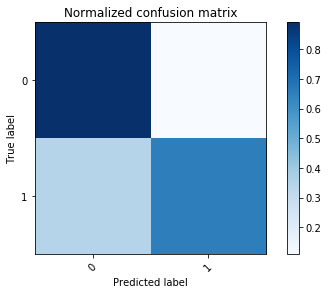

In [22]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

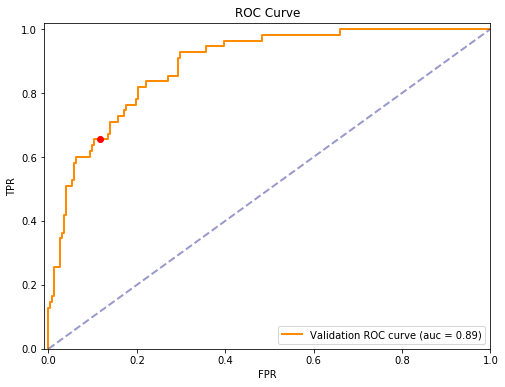

In [23]:
# ROC curve:______________________________________
validation_accuracy=best_lr.evaluate(test)
roc=validation_accuracy.roc.toPandas()
roc_auc=validation_accuracy.areaUnderROC

fig, ax = plt.subplots(figsize=(8,6)) 

plt.step(roc['FPR'],roc['TPR'], color='darkorange', lw=2, label='Validation ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')

plt.xlim([-0.01, 1])
plt.ylim([0.0, 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")

recall=validation_accuracy.recallByThreshold.toPandas()
recall=recall[np.round(recall['threshold'], 4)==0.5]['recall']
roc=validation_accuracy.roc.toPandas().iloc[recall.index[0]+1]
plt.plot(roc[0], roc[1], 'or')

plt.show()

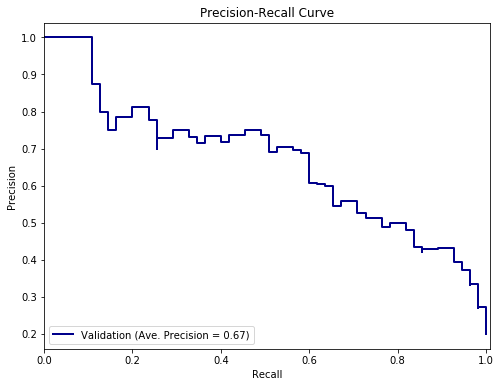

In [24]:
# Precision-Recall curve: ____________________________________________
validation_accuracy=best_lr.evaluate(test)
pr_test=validation_accuracy.pr.toPandas()

from pyspark.ml.evaluation import BinaryClassificationEvaluator
my_eval=BinaryClassificationEvaluator(metricName='areaUnderPR')
apr_test=my_eval.evaluate(best_lr.transform(test))

fig, ax = plt.subplots(figsize=(8,6)) 

plt.step(pr_test['recall'],pr_test['precision'], color='darkblue', lw=2, label='Validation (Ave. Precision = %0.2f)' % apr_test)

plt.xlim([0, 1.01])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

p_test=validation_accuracy.precisionByThreshold.toPandas()
r_test=validation_accuracy.recallByThreshold.toPandas()
p_test=p_test[np.round(p_test['threshold'], 5)==0.5]['precision']
r_test=r_test[np.round(r_test['threshold'], 5)==0.5]['recall']
plt.plot(r_test, p_test, 'ob')

plt.show()

# 2) Random Forest Model: 

In [25]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.BinaryClassificationEvaluator(metricName="areaUnderROC")
#evaluator=evaluation.MulticlassClassificationEvaluator(metricName="accuracy")

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(rf.maxDepth, [3, 5, 10])
grid=grid.addGrid(rf.numTrees, [70])
grid=grid.addGrid(rf.maxBins, [4, 8, 16, 32])

grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=rf,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=3,
                         seed=42)

In [26]:
# fit the model:
models=cv.fit(train)
best_rf=models.bestModel

# Best hyper-parameters: 
java_model = best_rf._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})

Best hyper-parameters:  {'numTrees': 70, 'maxBins': 32, 'maxDepth': 3}


In [27]:
# Prediction on test dataset:
test_predictions = best_rf.transform(test)
test_predictions.select('label', 'rawPrediction', 'probability', 'prediction').show(5)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  0.0|[65.6977869940298...|[0.93853981420042...|       0.0|
|  0.0|[68.3421428564501...|[0.97631632652071...|       0.0|
|  0.0|[66.0659372144968...|[0.94379910306424...|       0.0|
|  0.0|[68.4731253735471...|[0.97818750533638...|       0.0|
|  0.0|[68.3660082406264...|[0.97665726058037...|       0.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [28]:
my_eval= BinaryClassificationEvaluator(metricName='areaUnderROC')
print('Training roc_auc score: ', round(my_eval.evaluate(best_rf.transform(train)),2))
print('Validation roc_auc score: ', round(my_eval.evaluate(best_rf.transform(test)),2), '\n')

print('Training average precision: ', round(evaluator.evaluate(best_rf.transform(train), {evaluator.metricName: 'areaUnderPR'}), 2))
print('Validation average precision: ', round(evaluator.evaluate(best_rf.transform(test), {evaluator.metricName: 'areaUnderPR'}), 2), '\n')

my_eval= MulticlassClassificationEvaluator(metricName='f1')
print('Training f1 score: ', round(my_eval.evaluate(best_rf.transform(train)),2))
print('Validation f1 score: ', round(my_eval.evaluate(best_rf.transform(test)),2))

Training roc_auc score:  0.92
Validation roc_auc score:  0.88 

Training average precision:  0.77
Validation average precision:  0.68 

Training f1 score:  0.91
Validation f1 score:  0.85


In [29]:
# Prediction on test dataset:
test_predictions = best_rf.transform(test)
test_predictions.select('label', 'rawPrediction', 'probability', 'prediction').show(5)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  0.0|[65.6977869940298...|[0.93853981420042...|       0.0|
|  0.0|[68.3421428564501...|[0.97631632652071...|       0.0|
|  0.0|[66.0659372144968...|[0.94379910306424...|       0.0|
|  0.0|[68.4731253735471...|[0.97818750533638...|       0.0|
|  0.0|[68.3660082406264...|[0.97665726058037...|       0.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[212   9]
 [ 28  27]]
Normalized confusion matrix
[[0.96 0.04]
 [0.51 0.49]]


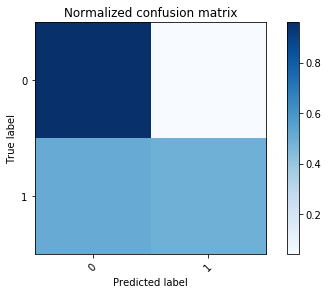

In [30]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.
class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

# Undersampling the majority class to balance the dataset for RF model:
    - Note: RF model doesn't get the "weightCol" parameter for the imbalanced dataset.
            So, we need to Undersample the majority class to improve Recall & Precision for minority class.

In [31]:
# Class 1 is majority here
ratio = train.filter(train['Churn']==1).count() / train.filter(train['Churn']==0).count()

undersampled_train = train.sampleBy('Churn', fractions={0: ratio, 1: 1.0}, seed=42)

undersampled_train.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|   95|
|    0|   91|
+-----+-----+



In [32]:
# fit the model on train dataset with Undersampled majority class:
models=cv.fit(undersampled_train)
best_rf=models.bestModel

# Best hyper-parameters: 
java_model = best_rf._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})

Best hyper-parameters:  {'numTrees': 70, 'maxBins': 4, 'maxDepth': 3}


In [33]:
my_eval= BinaryClassificationEvaluator(metricName='areaUnderROC')
print('Training roc_auc score: ', round(my_eval.evaluate(best_rf.transform(train)),2))
print('Validation roc_auc score: ', round(my_eval.evaluate(best_rf.transform(test)),2), '\n')

print('Training average precision: ', round(evaluator.evaluate(best_rf.transform(train), {evaluator.metricName: 'areaUnderPR'}), 2))
print('Validation average precision: ', round(evaluator.evaluate(best_rf.transform(test), {evaluator.metricName: 'areaUnderPR'}), 2), '\n')

my_eval= MulticlassClassificationEvaluator(metricName='f1')
print('Training f1 score: ', round(my_eval.evaluate(best_rf.transform(train)),2))
print('Validation f1 score: ', round(my_eval.evaluate(best_rf.transform(test)),2))

Training roc_auc score:  0.91
Validation roc_auc score:  0.88 

Training average precision:  0.69
Validation average precision:  0.62 

Training f1 score:  0.88
Validation f1 score:  0.84


In [34]:
# Prediction on test dataset:
test_predictions = best_rf.transform(test)
test_predictions.select('label', 'rawPrediction', 'probability', 'prediction').show(5)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  0.0|[55.8456975322322...|[0.79779567903188...|       0.0|
|  0.0|[64.2515282978933...|[0.91787897568419...|       0.0|
|  0.0|[57.9265496832266...|[0.82752213833180...|       0.0|
|  0.0|[63.8034903266925...|[0.91147843323846...|       0.0|
|  0.0|[58.2367553777862...|[0.83195364825408...|       0.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[189  32]
 [ 14  41]]
Normalized confusion matrix
[[0.86 0.14]
 [0.25 0.75]]


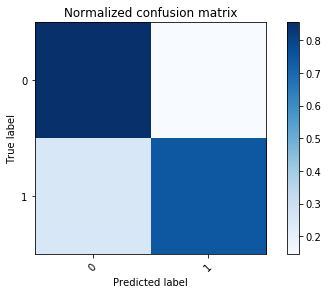

In [35]:
# Plot a confusion matrix:   
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

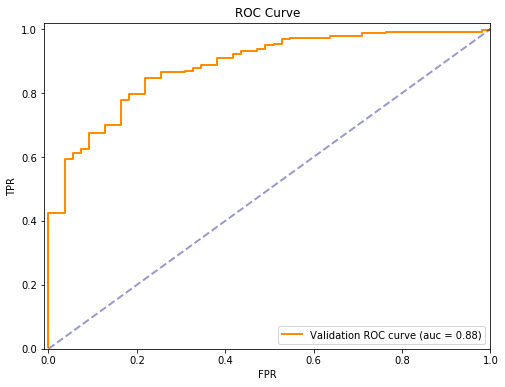

In [36]:
# ROC curve:______________________________________
prediction = best_rf.transform(test)
results= prediction.select(['probability', 'label']).collect()
results = [(i[0][0], 1.0-i[1]) for i in results]

from sklearn.metrics import roc_curve, auc
 
fpr= dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results]
y_score = [i[0] for i in results]
 
fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8,6)) 

plt.step(fpr, tpr, color='darkorange', lw=2, label='Validation ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')

plt.xlim([-.01, 1])
plt.ylim([0.0, 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")


plt.show()

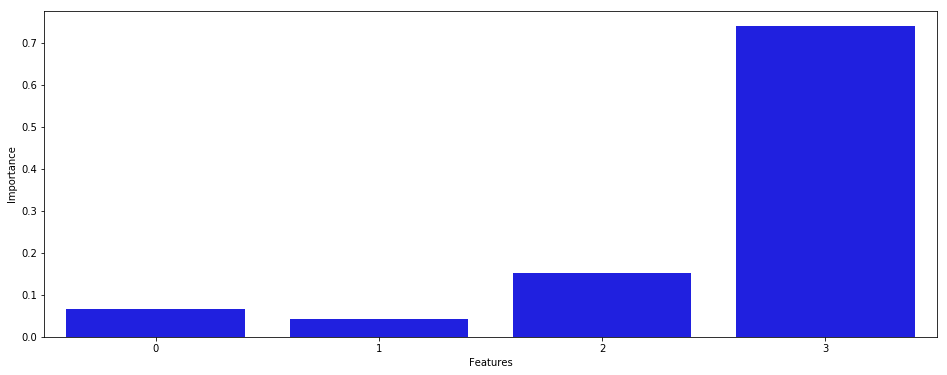

In [37]:
# Feature Importance: 
im=best_rf.featureImportances

# Plot:
c1=pd.DataFrame(im.toArray(),  columns=["Importance"])
c2=pd.DataFrame(np.arange(im.toArray().shape[0]), columns=["Features"])

fig, ax = plt.subplots(figsize=(16, 6)) 
sns.barplot(x="Features", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)

plt.show()

# 3) Gradient-Boosted Trees:

In [38]:
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(featuresCol = 'features', labelCol = 'label')

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.MulticlassClassificationEvaluator(metricName='f1')

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(gb.maxDepth, [2, 4, 6])
grid=grid.addGrid(gb.maxIter, [10, 20])
grid=grid.addGrid(gb.maxBins, [8, 16, 24, 32])

grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=gb,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=3,
                         seed=42)

In [39]:
# fit the model:
models=cv.fit(train)
best_gb=models.bestModel

# Best hyper-parameters: 
java_model = best_gb._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})

Best hyper-parameters:  {'maxBins': 32, 'maxDepth': 2, 'maxIter': 10}


In [40]:
print("Training f1 score:  ", round(evaluator.evaluate(best_gb.transform(train)),2))
print("Validation f1 score:  ", round(evaluator.evaluate(best_gb.transform(test)),2))

Training f1 score:   0.9
Validation f1 score:   0.85


In [41]:
# Prediction on test dataset:
test_predictions = best_gb.transform(test)
test_predictions.select('label', 'prediction').show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[213   8]
 [ 29  26]]
Normalized confusion matrix
[[0.96 0.04]
 [0.53 0.47]]


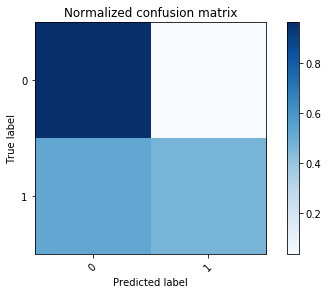

In [42]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.
class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

# Undersampling the majority class to balance the dataset for GBT model:
    - Note: Gradient-Boosted Trees model doesn't get the "weightCol" parameter for the imbalanced dataset.
            So, we need to Undersample the majority class to improve Recall & Precision for minority class.

In [43]:
# fit the model on train dataset with Undersampled majority class:
models=cv.fit(undersampled_train)
best_gb=models.bestModel

# Best hyper-parameters: 
java_model = best_gb._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})

Best hyper-parameters:  {'maxBins': 8, 'maxDepth': 2, 'maxIter': 10}


In [44]:
# Prediction on test dataset:
test_predictions = best_gb.transform(test)
test_predictions.select('label', 'prediction').show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



In [45]:
print("Training f1 score:  ", round(evaluator.evaluate(best_gb.transform(train)),2))
print("Validation f1 score:  ", round(evaluator.evaluate(best_gb.transform(test)),2))

Training f1 score:   0.84
Validation f1 score:   0.83


Confusion matrix, without normalization
[[184  37]
 [ 12  43]]
Normalized confusion matrix
[[0.83 0.17]
 [0.22 0.78]]


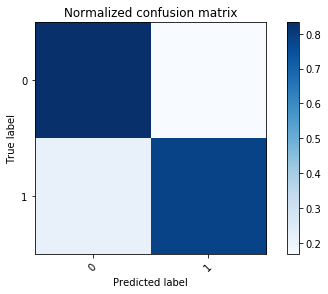

In [46]:
# Plot a confusion matrix:  
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

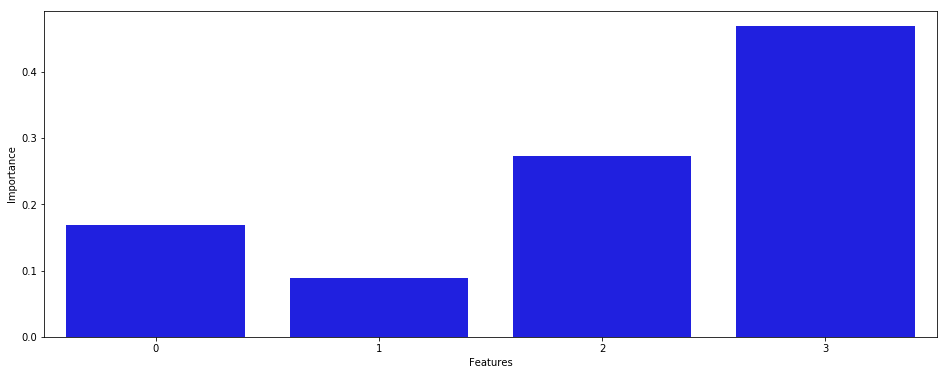

In [47]:
# Feature Importance: 
im=best_gb.featureImportances

# Plot:
c1=pd.DataFrame(im.toArray(),  columns=["Importance"])
c2=pd.DataFrame(np.arange(im.toArray().shape[0]), columns=["Features"])

fig, ax = plt.subplots(figsize=(16, 6)) 
sns.barplot(x="Features", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)

plt.show()